# Human sample level analysis

Main notebook to run sample-level simulation experiment using human gene expression data from recount2.

Make sure to run ```download_data.R``` download raw data

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

import os
import sys
import ast
import pandas as pd
import numpy as np
import random
import subprocess
from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(action='ignore')

sys.path.append("../")
from ponyo import pipeline, utils

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [3]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))
config_file = os.path.abspath(os.path.join(base_dir,
                                           "configs", 
                                           "config_Human_sample_limma.tsv"))
params = utils.read_config(config_file)

In [4]:
# Load parameters
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
analysis_name = params["simulation_type"]
correction_method = params["correction_method"]
lst_num_experiments = params["lst_num_experiments"]
train_architecture = params['NN_architecture']

In [5]:
# Input files
rpkm_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "recount2_gene_RPKM_data.tsv")

## Setup directories

In [6]:
pipeline.setup_dir(config_file)

## Pre-process data

In [7]:
# Output file
normalized_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "recount2_gene_normalized_data.tsv.xz")

In [8]:
# Only run pre-processind step if normalized data file is NOT created
if os.path.exists(normalized_data_file) == False:
    pipeline.normalize_expression_data(base_dir,
                                       config_file,
                                       rpkm_data_file)

## Train VAE

In [9]:
# Directory containing log information from VAE training
vae_log_dir = os.path.join(
    base_dir, 
    dataset_name,
    "logs",
    train_architecture)

input dataset contains 896 samples and 58037 genes
Train on 806 samples, validate on 90 samples
Epoch 1/40
806/806 [==============================] - 297s 368ms/step - loss: 8349.9469 - val_loss: 5660.8708
Epoch 2/40
806/806 [==============================] - 286s 355ms/step - loss: 5863.6263 - val_loss: 5594.4683
Epoch 3/40
806/806 [==============================] - 287s 356ms/step - loss: 5779.9224 - val_loss: 5424.6846
Epoch 4/40
806/806 [==============================] - 288s 357ms/step - loss: 5650.7489 - val_loss: 5391.5148
Epoch 5/40
806/806 [==============================] - 288s 357ms/step - loss: 5701.9353 - val_loss: 5363.3989
Epoch 6/40
806/806 [==============================] - 286s 355ms/step - loss: 5679.6096 - val_loss: 5275.3207
Epoch 7/40
806/806 [==============================] - 286s 355ms/step - loss: 5561.9723 - val_loss: 5273.8338
Epoch 8/40
806/806 [==============================] - 288s 357ms/step - loss: 5552.7388 - val_loss: 5189.0354
Epoch 9/40
806/806 [====

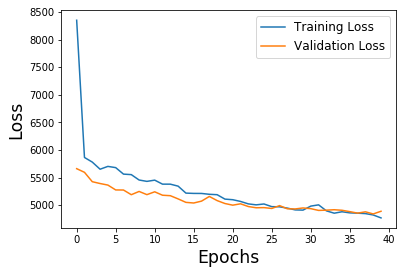

In [10]:
# Train VAE
# Check if VAE training completed first
#if len(os.listdir(vae_log_dir)) == 0:
pipeline.train_vae(config_file,
                   normalized_data_file)

## Run simulation experiment without noise correction

In [11]:
# Run simulation without correction 
corrected = False
pipeline.run_simulation(config_file,
                        normalized_data_file,
                        corrected)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed: 46.4min
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 46.4min remaining: 69.6min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed: 46.5min remaining: 31.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 46.5min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 46.5min finished
                          score
number of experiments          
1                      0.999991
2                      0.901448
5                      0.632603
10                     0.203977
20                     0.118938
50                     0.135414
100                    0.184654
250                    0.378679
500                    0.653348
                              score
number of experiments              
1                      2.815872e-07
2                      1.577455e-04
5                      2.284287e-03
10                    

## Run simulation with correction applied

In [12]:
# Run simulation without correction 
corrected = True
pipeline.run_simulation(config_file,
                        normalized_data_file,
                        corrected)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 38.6min remaining: 58.0min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed: 38.7min remaining: 25.8min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 38.7min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 38.7min finished
                          score
number of experiments          
1                      0.999991
2                      0.998663
5                      0.995652
10                     0.989930
20                     0.981173
50                     0.946037
100                    0.889085
250                    0.699587
500                    0.117121
                              score
number of experiments              
1                      2.649890e-07
2                      3.519406e-04
5                      2.567284e-04
10                    

## Make figures

In [11]:
pca_ind = [0,1,2,-3,-2,-1]

In [12]:
# File directories
similarity_uncorrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    "saved_variables",
    dataset_name + "_" + analysis_name + "_svcca_uncorrected_" + correction_method + ".pickle")

ci_uncorrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    "saved_variables",
    dataset_name + "_" + analysis_name + "_ci_uncorrected_" + correction_method + ".pickle")

similarity_corrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    "saved_variables",
    dataset_name + "_" + analysis_name + "_svcca_corrected_" + correction_method + ".pickle")

ci_corrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    "saved_variables",
    dataset_name + "_" + analysis_name + "_ci_corrected_" + correction_method + ".pickle")

permuted_score_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    "saved_variables",
    dataset_name + "_" + analysis_name + "_permuted.npy")

compendia_dir = os.path.join(
    local_dir,
    "experiment_simulated",
    dataset_name + "_" + analysis_name)

In [27]:
# Output files
svcca_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    dataset_name +"_"+analysis_name+"_svcca_"+correction_method+".svg")

svcca_png_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    dataset_name +"_"+analysis_name+"_svcca_"+correction_method+".png")

pca_uncorrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    dataset_name +"_"+analysis_name+"_pca_uncorrected_"+correction_method+".svg")

pca_corrected_file = os.path.join(
    base_dir,
    dataset_name,
    "results",
    dataset_name +"_"+analysis_name+"_pca_corrected_"+correction_method+".svg")

In [28]:
# Load pickled files
uncorrected_svcca = pd.read_pickle(similarity_uncorrected_file)
err_uncorrected_svcca = pd.read_pickle(ci_uncorrected_file)
corrected_svcca = pd.read_pickle(similarity_corrected_file)
err_corrected_svcca = pd.read_pickle(ci_corrected_file)

permuted_score = np.load(permuted_score_file)

In [29]:
# Concatenate error bars
uncorrected_svcca_err = pd.concat([uncorrected_svcca, err_uncorrected_svcca], axis=1)
corrected_svcca_err = pd.concat([corrected_svcca, err_corrected_svcca], axis=1)

In [30]:
# Add group label
uncorrected_svcca_err['Group'] = 'uncorrected'
corrected_svcca_err['Group'] = 'corrected'

In [31]:
# Concatenate dataframes
all_svcca = pd.concat([uncorrected_svcca_err, corrected_svcca_err])
all_svcca

,score,ymin,ymax,Group
number of experiments,,,,
1,0.999991,0.999991,0.999992,uncorrected
2,0.901448,0.901139,0.901757,uncorrected
5,0.632603,0.628126,0.637080,uncorrected
10,0.203977,0.201865,0.206089,uncorrected
20,0.118938,0.114939,0.122937,uncorrected
50,0.135414,0.126642,0.144187,uncorrected
100,0.184654,0.178988,0.190320,uncorrected
250,0.378679,0.374827,0.382532,uncorrected
500,0.653348,0.641934,0.664763,uncorrected


### SVCCA 

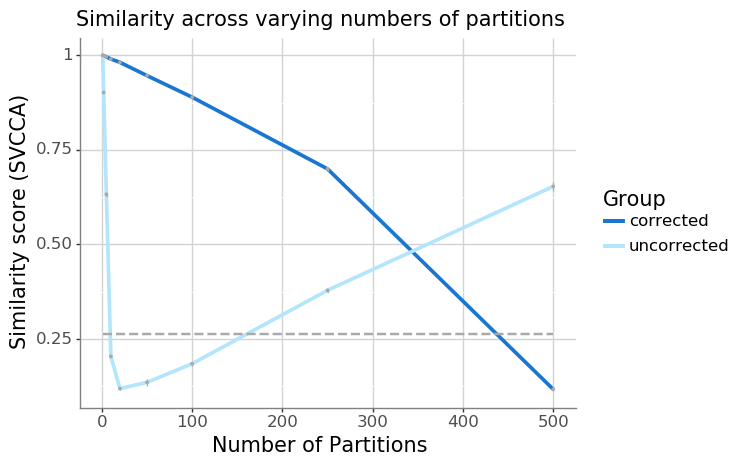

<ggplot: (8775087274013)>


In [32]:
# Plot
lst_num_partitions = list(all_svcca.index)

threshold = pd.DataFrame(
    pd.np.tile(
        permuted_score,
        (len(lst_num_partitions), 1)),
    index=lst_num_partitions,
    columns=['score'])

panel_A = ggplot(all_svcca) \
    + geom_line(all_svcca,
                aes(x=lst_num_partitions, y='score', color='Group'),
                size=1.5) \
    + geom_point(aes(x=lst_num_partitions, y='score'), 
                 color ='darkgrey',
                size=0.5) \
    + geom_errorbar(all_svcca,
                  aes(x=lst_num_partitions, ymin='ymin', ymax='ymax'),
                   color='darkgrey') \
    + geom_line(threshold, 
                aes(x=lst_num_partitions, y='score'), 
                linetype='dashed',
                size=1,
                color="darkgrey",
                show_legend=False) \
    + labs(x = "Number of Partitions", 
           y = "Similarity score (SVCCA)", 
           title = "Similarity across varying numbers of partitions") \
    + theme(
            plot_background=element_rect(fill="white"),
            panel_background=element_rect(fill="white"),
            panel_grid_major_x=element_line(color="lightgrey"),
            panel_grid_major_y=element_line(color="lightgrey"),
            axis_line=element_line(color="grey"),
            legend_key=element_rect(fill='white', colour='white'),
            legend_title=element_text(family='sans-serif', size=15),
            legend_text=element_text(family='sans-serif', size=12),
            plot_title=element_text(family='sans-serif', size=15),
            axis_text=element_text(family='sans-serif', size=12),
            axis_title=element_text(family='sans-serif', size=15)
           ) \
    + scale_color_manual(['#1976d2', '#b3e5fc']) \


print(panel_A)
ggsave(plot=panel_A, filename=svcca_file, device="svg", dpi=300)
ggsave(plot=panel_A, filename=svcca_png_file, device="svg", dpi=300)

### Uncorrected PCA

In [33]:
lst_num_experiments = [lst_num_experiments[i] for i in pca_ind]

all_data_df = pd.DataFrame()

# Get batch 1 data
experiment_1_file = os.path.join(
    compendia_dir,
    "Experiment_1_0.txt.xz")

experiment_1 = pd.read_table(
    experiment_1_file,
    header=0,
    index_col=0,
    sep='\t')


for i in lst_num_experiments:
    print('Plotting PCA of 1 experiment vs {} experiments...'.format(i))
    
    # Simulated data with all samples in a single batch
    original_data_df =  experiment_1.copy()
    
    # Add grouping column for plotting
    original_data_df['num_experiments'] = '1'
    
    # downsample
    original_data_df = original_data_df.sample(n=500)
    
    # Get data with additional batch effects added
    experiment_other_file = os.path.join(
        compendia_dir,
        "Experiment_"+str(i)+"_0.txt.xz")

    experiment_other = pd.read_table(
        experiment_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Simulated data with i batch effects
    experiment_data_df =  experiment_other
    
    # Add grouping column for plotting
    experiment_data_df['num_experiments'] = 'multiple'
    
    # downsample
    experiment_data_df = experiment_data_df.sample(n=500)
    
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, experiment_data_df])

    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space
    combined_data_numeric_df = combined_data_df.drop(['num_experiments'], axis=1)
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)


    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
                                              
    # Variance explained
    print(pca.explained_variance_ratio_)  
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['num_experiments'] = combined_data_df['num_experiments']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['comparison'] = str(i)
    
    # Concatenate ALL comparisons
    all_data_df = pd.concat([all_data_df, combined_data_PCAencoded_df])   

Plotting PCA of 1 experiment vs 1 experiments...
[0.29599061 0.15003598]
Plotting PCA of 1 experiment vs 2 experiments...
[0.6385757  0.31959061]
Plotting PCA of 1 experiment vs 5 experiments...
[0.21613532 0.21514729]
Plotting PCA of 1 experiment vs 100 experiments...
[0.01238571 0.01028361]
Plotting PCA of 1 experiment vs 250 experiments...
[0.0107596  0.00648701]
Plotting PCA of 1 experiment vs 500 experiments...
[0.01045338 0.00591998]


In [34]:
# Convert 'num_experiments' into categories to preserve the ordering
lst_num_experiments_str = [str(i) for i in lst_num_experiments]
num_experiments_cat = pd.Categorical(all_data_df['num_experiments'], categories=['1', 'multiple'])

# Convert 'comparison' into categories to preserve the ordering
comparison_cat = pd.Categorical(all_data_df['comparison'], categories=lst_num_experiments_str)

# Assign to a new column in the df
all_data_df = all_data_df.assign(num_experiments_cat = num_experiments_cat)
all_data_df = all_data_df.assign(comparison_cat = comparison_cat)

In [35]:
all_data_df.columns = ['PC1', 'PC2', 'num_experiments', 'comparison', 'No. of experiments', 'Comparison']

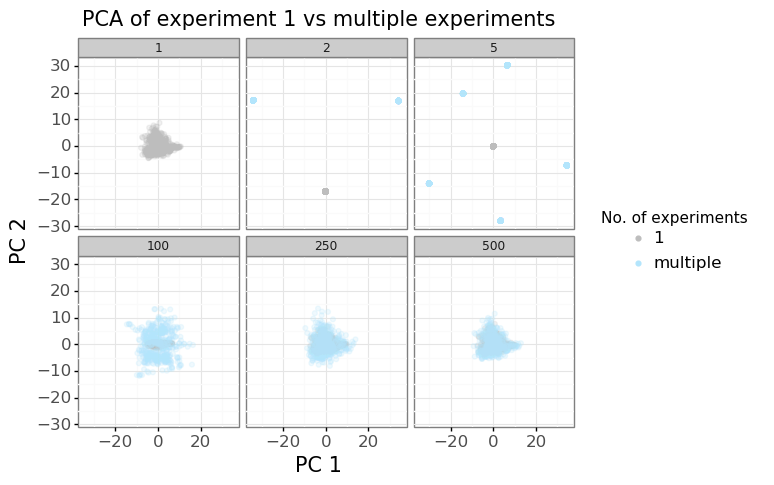

<ggplot: (8775087183389)>


In [36]:
# Plot all comparisons in one figure
panel_B = ggplot(all_data_df[all_data_df['Comparison'] != '1'],
                 aes(x='PC1', y='PC2')) \
    + geom_point(aes(color='No. of experiments'), 
                 alpha=0.2) \
    + facet_wrap('~Comparison') \
    + labs(x = "PC 1", 
           y = "PC 2", 
           title = "PCA of experiment 1 vs multiple experiments") \
    + theme_bw() \
    + theme(
        legend_title_align = "center",
        plot_background=element_rect(fill='white'),
        legend_key=element_rect(fill='white', colour='white'), 
        legend_text=element_text(family='sans-serif', size=12),
        plot_title=element_text(family='sans-serif', size=15),
        axis_text=element_text(family='sans-serif', size=12),
        axis_title=element_text(family='sans-serif', size=15)
    ) \
    + guides(colour=guide_legend(override_aes={'alpha': 1})) \
    + scale_color_manual(['#bdbdbd', '#b3e5fc']) \
    + geom_point(data=all_data_df[all_data_df['Comparison'] == '1'],
                 alpha=0.1, 
                 color='#bdbdbd')

print(panel_B)
ggsave(plot=panel_B, filename=pca_uncorrected_file, dpi=300)

### Corrected PCA

In [37]:
lst_num_experiments = [lst_num_experiments[i] for i in pca_ind]

all_corrected_data_df = pd.DataFrame()

# Get batch 1 data
experiment_1_file = os.path.join(
    compendia_dir,
    "Experiment_corrected_1_0.txt.xz")

experiment_1 = pd.read_table(
    experiment_1_file,
    header=0,
    index_col=0,
    sep='\t')

# Transpose data to df: sample x gene
experiment_1 = experiment_1.T

for i in lst_num_experiments:
    print('Plotting PCA of 1 experiment vs {} experiments...'.format(i))
    
     # Simulated data with all samples in a single batch
    original_data_df =  experiment_1.copy()
    
    # Match format of column names in before and after df
    original_data_df.columns = original_data_df.columns.astype(str)
    
    # Add grouping column for plotting
    original_data_df['num_experiments'] = '1'
    
    # downsample
    original_data_df = original_data_df.sample(n=500)
    
    # Get data with additional batch effects added and corrected
    experiment_other_file = os.path.join(
        compendia_dir,
        "Experiment_corrected_"+str(i)+"_0.txt.xz")

    experiment_other = pd.read_table(
        experiment_other_file,
        header=0,
        index_col=0,
        sep='\t')
    
    # Transpose data to df: sample x gene
    experiment_other = experiment_other.T
    
    # Simulated data with i batch effects that are corrected
    experiment_data_df =  experiment_other
    
    # Match format of column names in before and after df
    experiment_data_df.columns = experiment_data_df.columns.astype(str)
    
    # Add grouping column for plotting
    experiment_data_df['num_experiments'] = 'multiple'
    
    # downsample
    experiment_data_df = experiment_data_df.sample(n=500)
        
    # Concatenate datasets together
    combined_data_df = pd.concat([original_data_df, experiment_data_df])
    
    # PCA projection
    pca = PCA(n_components=2)

    # Encode expression data into 2D PCA space    
    combined_data_numeric_df = combined_data_df.drop(['num_experiments'], axis=1)    
    combined_data_PCAencoded = pca.fit_transform(combined_data_numeric_df)

    
    combined_data_PCAencoded_df = pd.DataFrame(combined_data_PCAencoded,
                                               index=combined_data_df.index,
                                               columns=['PC1', 'PC2']
                                              )
    
    # Add back in batch labels (i.e. labels = "batch_"<how many batch effects were added>)
    combined_data_PCAencoded_df['num_experiments'] = combined_data_df['num_experiments']
    
    # Add column that designates which batch effect comparision (i.e. comparison of 1 batch vs 5 batches
    # is represented by label = 5)
    combined_data_PCAencoded_df['comparison'] = str(i)
    
    # Concatenate ALL comparisons
    all_corrected_data_df = pd.concat([all_corrected_data_df, combined_data_PCAencoded_df])

Plotting PCA of 1 experiment vs 1 experiments...
Plotting PCA of 1 experiment vs 2 experiments...
Plotting PCA of 1 experiment vs 5 experiments...
Plotting PCA of 1 experiment vs 100 experiments...
Plotting PCA of 1 experiment vs 250 experiments...
Plotting PCA of 1 experiment vs 500 experiments...


In [38]:
# Convert 'num_experiments' into categories to preserve the ordering
lst_num_experiments_str = [str(i) for i in lst_num_experiments]
num_experiments_cat = pd.Categorical(all_corrected_data_df['num_experiments'], categories=['1', 'multiple'])

# Convert 'comparison' into categories to preserve the ordering
comparison_cat = pd.Categorical(all_corrected_data_df['comparison'], categories=lst_num_experiments_str)

# Assign to a new column in the df
all_corrected_data_df = all_corrected_data_df.assign(num_experiments_cat = num_experiments_cat)
all_corrected_data_df = all_corrected_data_df.assign(comparison_cat = comparison_cat)

In [39]:
all_corrected_data_df.columns = ['PC1', 'PC2', 'num_experiments', 'comparison', 'No. of experiments', 'Comparison']

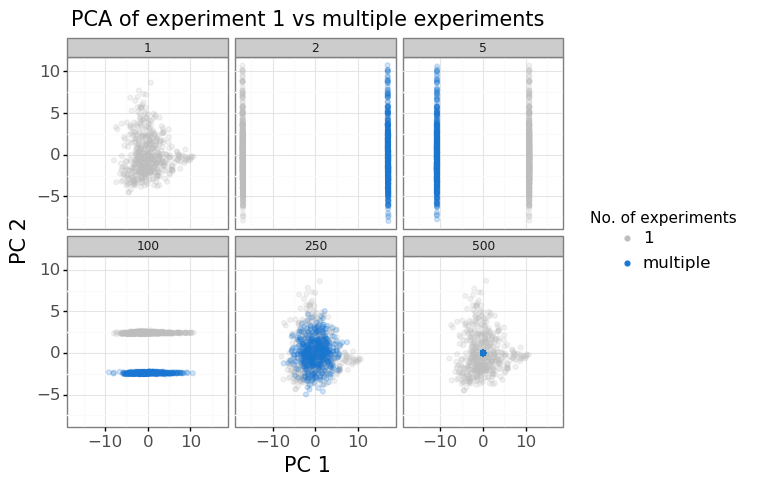

<ggplot: (-9223363261821295868)>


In [40]:
# Plot all comparisons in one figure
panel_C = ggplot(all_corrected_data_df[all_corrected_data_df['Comparison'] != '1'],
                 aes(x='PC1', y='PC2')) \
    + geom_point(aes(color='No. of experiments'), 
                 alpha=0.2) \
    + facet_wrap('~Comparison') \
    + labs(x = "PC 1",
           y = "PC 2", 
           title = "PCA of experiment 1 vs multiple experiments") \
    + theme_bw() \
    + theme(
        legend_title_align = "center",
        plot_background=element_rect(fill='white'),
        legend_key=element_rect(fill='white', colour='white'), 
        legend_text=element_text(family='sans-serif', size=12),
        plot_title=element_text(family='sans-serif', size=15),
        axis_text=element_text(family='sans-serif', size=12),
        axis_title=element_text(family='sans-serif', size=15)
    )\
    + guides(colour=guide_legend(override_aes={'alpha': 1})) \
    + scale_color_manual(['#bdbdbd', '#1976d2']) \
    + geom_point(data=all_corrected_data_df[all_corrected_data_df['Comparison'] == '1'],
                 alpha=0.1, 
                 color='#bdbdbd')

print(panel_C)
ggsave(plot=panel_C, filename=pca_corrected_file, dpi=300)